In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import scipy
import requests
from matplotlib.patches import Rectangle
from datetime import datetime

# COVID-19 Data Cleaning


# Table of contents<a id='toc'></a>

## [1. Introduction](#intro)

## [2. Data wrangling function definitions](#functions)

## [3. Data description](#data)

## [4. Data importation and reformatting](#reformat)

## [5. Data regularization](#uniformity)

## [6. Feature engineering and selection](#features)


# 1. Introduction <a id='intro'></a>

The main focus of this project is to compare 

The key cleaning measures are those which find the most viable set of countries and date ranges
such that the maximal amount of data can be used. In other words, different datasets can have data
on a different set of countries; to avoid introducing large quantities of missing values
the intersection of these countries is taken.

<a id='functions'></a>
# 2. Data wrangling functions

In [2]:
def country_search(df, country):
    """ saves space when you want indices for separate countries"""
    return df[df.location==country].index

def country_groupby(df):
    """ saves space, written to supplement Pandas groupby when the indices are desired"""
    return [df[df.location==country].index for country in df.location.unique()]


def column_search(df, name, return_style='loc', threshold='contains'):
    """ Partial/full matching of column names returning either Pandas .loc or .iloc compatible indices """
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

def reformat_values(values_to_transform, category='columns',dateformat=None):
    """ Reformat column and index names. 
    
    Parameters :/
    ----------
    df : Pandas DataFrame
    columns : bool
    index : bool|
    
    Notes :
    -----
    Change headers of columns; this needs to be updated to account for their formatting changes. 
    This function converts strings with CamelCase, underscore and space separators to lowercase words uniformly
    separated with underscores. I.e. (hopefully!) following the correct python identifier syntax so that each column
    can be reference as an attribute if desired. 

    For more on valid Python identifiers, see:
    https://docs.python.org/3/reference/lexical_analysis.html#identifiers
    """
    
    """ Reformat column and index names. only works with with pandas MultiIndex for level=0.
    
    Parameters :
    ----------
    df : Pandas DataFrame

    Notes :
    -----
    Different datasets have different naming conventions (for countries that go by multiple names and abbreviations).
    This function imposes a convention on a selection of these country names.  
    """
    # these lists are one-to-one. countries compared via manual inspection, unfortunately. 
    mismatch_labels_bad = ['Lao People\'s Democratic Republic', 'Mainland China',
                           'Occupied Palestinian Territory','Republic of Korea', 'Korea, South', 
                           'Gambia, The ', 'UK', 
                           'USA', 'Iran (Islamic Republic of)',
                           'Bahamas, The', 'Russian Federation', 'Czech Republic', 'Republic Of Ireland',
                          'Hong Kong Sar', 'Macao Sar', 'Uk','Us',
                           'Congo ( Kinshasa)','Congo ( Brazzaville)',
                           'Cote D\' Ivoire', 'Viet Nam','Guinea- Bissau','Guinea','Usa']

    mismatch_labels_good = ['Laos','China',
                            'Palestine', 'South Korea', 'South Korea', 
                            'The Gambia', 'United Kingdom', 
                            'United States','Iran',
                            'The Bahamas','Russia','Czechia','Ireland',
                            'Hong Kong','Macao','United Kingdom', 'United States',
                            'Democratic Republic Of The Congo','Republic Of The Congo',
                            'Ivory Coast','Vietnam', 'Guinea Bissau','Guinea Bissau','United States']
    
    # three cases, column names, country names, or datetime. 
    if category == 'location':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append(' '.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                        re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val).lower())
                                                        .split()).title())
        transformed_values = pd.Series(reformatted_values).replace(to_replace=mismatch_labels_bad, value=mismatch_labels_good)
    
    elif category == 'columns':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append('_'.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                     re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val)
                                                            .lower()).split()))
        transformed_values = pd.Series(reformatted_values)
        
    elif category == 'date':
        transformed_values = pd.to_datetime(pd.Series(
            values_to_transform), errors='coerce',format=dateformat).dt.normalize()


    return transformed_values

#----------------- Helper Functions for regularization ----------------------#
def intersect_country_index(df, country_intersection):
    df_tmp = df.copy().reset_index(level=0)
    df_tmp = df_tmp[df_tmp.location.isin(country_intersection)]
    df_tmp = df_tmp.set_index(['location', df_tmp.index])
    return df_tmp 

def resample_dates(df, dates):
    df = df.loc[~df.index.duplicated(keep='first')]
    return df.reindex(pd.MultiIndex.from_product([df.index.levels[0], dates], names=['location', 'date']), fill_value=np.nan)

def make_multilevel_columns(df):
    df.columns = pd.MultiIndex.from_product([[df.columns.name], df.columns], names=['dataset', 'features'])
    return df

def multiindex_to_table(df):
    df_table = df.copy()
    try:
        df_table.columns = df_table.columns.droplevel()
        df_table.columns.names = ['']
    except:
        pass
    df_table = df_table.reset_index()
    return df_table

#----------------- Manipulation flagging ----------------------#


def regularize_names(df, datekey=None, locationkey=None, dateformat=None):
    df.columns = reformat_values(df.columns, category='columns').values
    if datekey is not None:
        df.loc[:, 'date'] = reformat_values(df.loc[:, datekey], category='date', dateformat=None).values
    if locationkey is not None:
        df.loc[:, 'location'] =  reformat_values(df.loc[:, locationkey], category='location').values
    return df


def add_time_indices(data_table, index_column='cases'):
    indexer = ((data_table.loc[:, ['location', index_column]].replace(to_replace=np.nan, value=0)
               ).replace(to_replace=0, value=np.nan).dropna().reset_index()
              )
    country_groupby_indices = country_groupby(data_table)
    country_groupby_indices_dropped_nan = country_groupby(indexer)
    days_since = []
    for i, c in enumerate(country_groupby_indices_dropped_nan):
        nonzero_list = list(range(len(c)))
        zero_list = 0*np.array(list(range(len(country_groupby_indices[i])-len(c))))
        days_since += list(zero_list)+nonzero_list
    print(len(days_since),len(data_table))
    data_table.loc[:, 'days_since_first_case'] = days_since
    data_table.loc[:, 'time_index'] = len(data_table.location.unique())*list(range(len(data_table.date.unique())))
    return data_table

def regularize_time_series(df_list, location_operation='intersection', date_operation='union'):
    locations = df_list[0].index.levels[0].unique()
    dates =  df_list[0].index.levels[1].unique()
    for i in range(len(df_list)-1):
        if location_operation == 'intersection':
            locations = locations.intersection(df_list[i+1].index.levels[0].unique())
        # not really intersection, this is the minimum date that at least one locations has data for, in each dataset.
        elif location_operation == 'union':
            locations = locations.union(df_list[i+1].index.levels[0].unique())
            
        if date_operation == 'intersection':
            dates = dates.intersection(df_list[i+1].index.levels[1].unique())
        elif date_operation == 'union':
            dates = dates.union(df_list[i+1].index.levels[1].unique())
    df_list = [intersect_country_index(df, locations) for df in df_list]
    #This redefines the time series for all variables as from December 31st 2019 to the day with most recent data
    time_normalized_global_data = [resample_dates(df, dates.normalize()) for df in df_list]
    # To keep track of which data came from where, make the columns multi level with the first level labelling the dataset.
    return time_normalized_global_data, dates, locations

def rolling_features(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = (df.loc[:,features].fillna(value=0.)
                   ).groupby(df.location).rolling(window).mean().fillna(value=0.)
        rollstd = (df.loc[:,features].fillna(value=0.)
                   ).groupby(df.location).rolling(window).std().fillna(value=0.)

        new_features = pd.concat((rollmean, rollstd), axis=1)
        mean_cols = pd.Index(features) +'_rolling_mean_' + str(window)
        std_cols = pd.Index(features) +'_rolling_std_' + str(window)
        new_cols = mean_cols.append(std_cols)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return pd.concat(new_feature_df_list, axis=1)


def fix_incorrect_decrease(df, feature, search_threshold='match'):
    df_tmp = df.copy()
    matching_columns = column_search(df_tmp, feature, return_style='iloc', threshold=search_threshold) 
    feature_index =  matching_columns[df_tmp.iloc[:, matching_columns].isna().sum().values.argmin()]
    location_index =  column_search(df_tmp, 'location', return_style='iloc', threshold=search_threshold)[0] 
    decreasing_indices = np.where(df_tmp.iloc[:, [location_index, feature_index]].groupby('location').diff(1)< 0)[0].ravel()
    n_countries_with_missing = len(df_tmp.iloc[decreasing_indices, location_index].unique().tolist())
    print('Fixing {} countries in the ''{}'' column feature'.format(
        n_countries_with_missing, df_tmp.iloc[:, feature_index].name)) 
    # premptive filling, not related to decreasing but rather missing values.
    decreasing_incorrectly = []
    flag = True
    
    # flag is switched off immediately, but will be switched on if any values are changed.
    df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(method='ffill')
    df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(0)
    while flag:
        flag = False
        decreasing_indices = np.where(df_tmp.iloc[:, [location_index, feature_index]].groupby('location').diff(1)< 0)[0].ravel()
        if decreasing_indices.size > 0:
            countries_with_missing = df_tmp.iloc[decreasing_indices, location_index].unique().tolist()
            flag = True
            df_tmp.iloc[decreasing_indices, feature_index] = np.nan
            df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(method='ffill')
            df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(0)
    return df_tmp

def rolling_means(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = None
        for c in country_groupby(df):
            if rollmean is None:
                rollmean = df.loc[c, features].rolling(window).mean().fillna(value=0.)
            else:
                rollmean = pd.concat((rollmean,  df.loc[c,features].rolling(window).mean().fillna(value=0.)),axis=0)
        new_features = rollmean
        new_cols = pd.Index(features) +'_rolling_mean_' + str(window)

        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return pd.concat(new_feature_df_list,axis=1)

def new_average_feature(data, features, new_feature_name):
    data.loc[:, new_feature_name] = data.loc[:, features].mean(1).fillna(0).values
    return None

def modify_time_series_zeros(df, features):
    df_modified = df.copy()
    df_modified.loc[:, features] = \
        (df_modified.loc[:, features].replace(to_replace=0., value=np.nan)
        ).groupby(df.location).fillna(method='ffill').fillna(value=0)
    return df_modified

<a id='data'></a>
# 3. Describing the data

[Return to table of contents](#toc)
### 3.1 JHU CSSE case data | [Go to wrangling section](#csse)

**Data available via github**
[https://github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

This data is split between a collection of .csv files of two different formats; first, the daily reports (global) are
separated by day, each residing in their own .csv. Additionally, the daily report files have three different formats that need to be taken into account when compiling the data. The daily report data itself contains values on the number of confirmed cases, deceased, active cases, recovered cases.

For the other format, .csv files with 'timeseries' in their filename, the data contains values for confirmed, deceased, recovered and are split between global numbers (contains United States as a whole) and numbers for the united states (statewide).
           
           
### 3.2 OWID case and test data | [Go to wrangling section](#OWID)

**Data available via github**
[https://github.com/owid/covid-19-data](https://github.com/owid/covid-19-data)

The OWID dataset contains information regarding case and test numbers; it overlaps with the JHU CSSE 
and Testing Tracker datasets but I am going to attempt to use it in conjunction with those two because
of how there is unreliable reporting. In other words to get the bigger picture I'm looking to stitch together
multiple datasets.

           
### 3.3 OxCGRT government response data | [Go to wrangling section](#oxcgrt)

**Data available via github**
[https://github.com/OxCGRT/covid-policy-tracker/](https://github.com/OxCGRT/covid-policy-tracker/)

The OxCGRT dataset contains information regarding different government responses in regards to social
distancing measures. It measures the type of social distancing measure, whether or not they are recommended
or mandated, whether they are targeted or broad (I think geographically). 
           
### 3.4 Testing tracker data | [Go to wrangling section](#testtrack)
<!-- **Website which lead me to dataset**
[https://www.statista.com/statistics/1109066/coronavirus-testing-in-europe-by-country/](https://www.statista.com/statistics/1109066/coronavirus-testing-in-europe-by-country/) -->

**Data available at:**
[https://finddx.shinyapps.io/FIND_Cov_19_Tracker/](https://finddx.shinyapps.io/FIND_Cov_19_Tracker/)

This dataset contains a time series of testing information: e.g. new (daily) tests, cumulative tests, etc. 

<a id='reformat'></a>
# 4. Data importation and reformatting
[Return to table of contents](#toc)

The following sections labeled by the corresponding data set reformats them such that the data
is stored in a pandas DataFrame with a multiindex; level=0 -> 'location' (country or region) and
level=1 -> date. The multiindex usage is deprecated and later removed, but for the sake of merging the DataFrames and dependent code I've left it in this beginning stage. It has instead been replaced by a simple table format and the writing/inclusion of special helper functions to slice the DataFrames by countries and time. Due to the nature of the data this is done separately for country-wide and united states-wide locations.

The main cleaning steps are to import the data, rename the columns and location names such that they are consistent between DataFrames. After the main aggregation and cleaning steps, the datasets are then exported to new local versions and then sent along for further processing.

The names are regularized because the different datasets have different conventions for how to list the dates and country names. Obviously if we are to compare time series of countries then both of these have to be regularized. The date is reformatted in such a matter such that pandas can easily convert the feature column into a datetime variable. The location names are modified by both changing the names of certain countries and then also removing special spellings and symbols from the name of locations as well as feature names. The features are formatted such that their names are valid python identifiers which enables for use of the attribute syntax (i.e. using the syntax ```data.feature```). The location names are formatted such that words are separated by spaces and that no countries are listed as their abbreviations (for example, the 'U.K.' is listed as 'United Kingdom'. While it technically makes some country names incorrect, I've opted to remove most articles; so it is not 'The United States' it is simply 'United States'. This part of the cleaning is performed using regex. 

## 4.1 JHU CSSE case data
<a id='csse'></a>
[Return to table of contents](#toc)

This data is in a collection of comma separated value files, and as such I iterate over the csv filenames using the glob package, such that they can be imported and the time series can be sorted by location. There are a collection of csv's for both global data and state-wide data (for the United States). In the global data there are cases, deaths, and recovered numbers. For the U.S.A, there is only cases and deaths. Both datasets start on January 22nd. 

In [3]:
global_df_list = []

for x in glob.glob('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/*_global.csv'):
    tmp_df = pd.read_csv(x)
    catcols = tmp_df.iloc[:, :4]
    datecols = tmp_df.iloc[:, 4:]
    catcols.columns = reformat_values(catcols.columns, category='columns').values
    catcols.loc[:, 'location'] =  reformat_values(catcols.loc[:, 'country_region'], category='location').values
    datecols.columns = reformat_values(datecols.columns, category='date').values
    global_tmp = pd.concat((catcols.location,datecols),axis=1).groupby(by='location').sum().sort_index()
    # keep the name of the data; i.e. 'confirmed', 'deaths', etc.
    time_series_name = x.split('_')[-2]
    global_df_list.append(global_tmp.stack().to_frame(name=time_series_name))

# Rename the columns
csse_global_time_series_df = pd.concat(global_df_list, axis=1)
csse_global_time_series_df.index.names = ['location','date']
csse_global_time_series_df.columns.names = ['csse_global_timeseries']
csse_global_time_series_df.columns = ['cases', 'deaths', 'recovered']
csse_global_time_series_df = csse_global_time_series_df.reset_index()

# Do the country georgia separately in-case data ever contains U.S. states info.
geor_index = csse_global_time_series_df[csse_global_time_series_df.location=='Georgia'].index
csse_global_time_series_df.loc[geor_index, 'location'] = 'Sakartvelo' 
csse_global_time_series_df.loc[:, 'date'] = pd.to_datetime(csse_global_time_series_df.loc[:,'date']).values
csse_global_time_series_df = csse_global_time_series_df.set_index(['location', 'date'])

Sample of the global data's DataFrame. 

In [4]:
csse_global_time_series_df.sample(5)

,,cases,deaths,recovered
location,date,,,
Malaysia,2020-03-25,1796,20,199
Cyprus,2020-06-21,986,19,824
Gabon,2020-02-03,0,0,0
Finland,2020-04-17,3489,82,1700
Congo Brazzaville,2020-02-16,0,0,0


In [5]:
usa_df_list = []
for x in glob.glob('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/*_US.csv'):
    # Import, process the date columns (i.e. for the time series) and the categorical columns.  
    tmp_df = pd.read_csv(x)
    catcols = tmp_df.iloc[:, :np.where(tmp_df.columns == '1/22/20')[0][0]]
    catcols.columns = reformat_values(catcols.columns, category='columns').values
    catcols.loc[:, 'location'] =  catcols.loc[:, 'province_state'].values
    
    datecols = tmp_df.iloc[:,np.where(tmp_df.columns == '1/22/20')[0][0]:]
    datecols.columns = reformat_values(datecols.columns, category='date').values
    usa_tmp = pd.concat((catcols.location,datecols),axis=1).groupby(by='location').sum().sort_index()
    # keep the name of the data; i.e. 'confirmed', 'deaths', etc.
    time_series_name = x.split('_')[-2]
    usa_df_list.append(usa_tmp.stack().to_frame(name=time_series_name))
    
csse_usa_time_series_df = pd.concat(usa_df_list,axis=1)#.reset_index(drop=True)
csse_usa_time_series_df.index.names = ['location','date']
csse_usa_time_series_df.columns.names = ['csse_us_timeseries']
csse_usa_time_series_df.columns = ['cases', 'deaths']
csse_usa_time_series_df = csse_usa_time_series_df.reset_index()

csse_usa_time_series_df.loc[:, 'date'] = pd.to_datetime(csse_usa_time_series_df.loc[:,'date']).values
csse_usa_time_series_df = csse_usa_time_series_df.set_index(['location', 'date'])

Sample of the United States specific data.

In [6]:
csse_usa_time_series_df.sample(5)

,,cases,deaths
location,date,,
Mississippi,2020-05-25,13458,635
New York,2020-03-16,967,21
Colorado,2020-03-04,0,0
Nevada,2020-06-10,10218,449
New Mexico,2020-01-30,0,0


## 4.2 OWID case and test data
<a id='OWID'></a>
[Return to table of contents](#toc)

The "Our World in Data" dataset contains time series information on the cases, tests, and deaths. Some of these features are cumulative while others represent the daily change with and without normalization by capita. Other features were added while this and the other notebooks were being written, most of these are time-independent features (or at least have a long time scale) such as numerical quantification of the poverty rate of the country. 

In [7]:
owid_df =pd.read_csv('../covid-19-data/public/data/owid-covid-data.csv')
owid_df = regularize_names(owid_df, datekey='date', locationkey='location').set_index(['location', 'date']).sort_index()
# I am also using the dataset from which this feature originates.
owid_df = owid_df.drop(columns='stringency_index')

Show a sample of the OWID data set.

In [8]:
owid_df.sample(5)

,,iso_code,continent,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
location,date,,,,,,,,,,,,,,,,,,,,,
Guam,2020-04-10,GUM,Oceania,128.0,3.0,4.0,0.0,758.370,17.774,23.699,0.000,...,5.493,NaN,NaN,310.496,21.52,NaN,NaN,NaN,NaN,80.07
Hungary,2020-05-01,HUN,Europe,2863.0,88.0,323.0,11.0,296.366,9.109,33.436,1.139,...,11.976,26777.561,0.5,278.296,7.55,26.8,34.8,NaN,7.02,76.88
Timor,2020-07-01,TLS,Asia,24.0,0.0,0.0,0.0,18.203,0.000,0.000,0.000,...,1.897,6570.102,30.3,335.346,6.86,6.3,78.1,28.178,5.90,69.50
Slovakia,2020-06-02,SVK,Europe,1522.0,0.0,28.0,0.0,278.773,0.000,5.129,0.000,...,9.167,30155.152,0.7,287.959,7.29,23.1,37.7,NaN,5.82,77.54
Australia,2020-04-29,AUS,Oceania,6738.0,13.0,88.0,4.0,264.237,0.510,3.451,0.157,...,10.129,44648.710,0.5,107.791,5.07,13.0,16.5,NaN,3.84,83.44


## 4.3 OxCGRT government response data
<a id='oxcgrt'></a>
[Return to table of contents](#toc)

Manual importation of data (for whatever reason this data set is different from pulling using their API). This
dataset contains time series information for the different social distancing and quarantine measures. The time
series are recorded using flags which indicate whether or not a measure is in place, recommended, or not considered.
In addition, there are addition flags which augment these time series; indicating whether or not the measures are targeted
or general. Lastly are features which quantify important government actions such as the 'economic support index'. Perhaps the most important of these features are a handful of engineered "index" features which aggregate and quantify government responses with a score from 0 to 100. For example, the "stringency index" feature is a quantity measured from 0 to 100 representing the strictness of government social distancing guidelines. Subcomponents of "stringency" include cancelling public gatherings, closing schools, etc. 

In [9]:
oxcgrt_df = regularize_names(pd.read_csv('../covid-policy-tracker/data/OxCGRT_latest.csv'), locationkey='country_name')
oxcgrt_df.loc[:, 'date'] = pd.to_datetime(oxcgrt_df.loc[:, 'date'], format='%Y%m%d')
oxcgrt_df = oxcgrt_df.set_index(['location', 'date'])

In [10]:
oxcgrt_df.sample(5)

,,country_name,country_code,c1_school_closing,c1_flag,c2_workplace_closing,c2_flag,c3_cancel_public_events,c3_flag,c4_restrictions_on_gatherings,c4_flag,...,stringency_index,stringency_index_for_display,stringency_legacy_index,stringency_legacy_index_for_display,government_response_index,government_response_index_for_display,containment_health_index,containment_health_index_for_display,economic_support_index,economic_support_index_for_display
location,date,,,,,,,,,,,,,,,,,,,,,
Mongolia,2020-06-14,Mongolia,MNG,3.0,1.0,2.0,1.0,2.0,1.0,4.0,1.0,...,62.96,62.96,67.86,67.86,61.54,61.54,63.64,63.64,50.0,50.0
Solomon Islands,2020-02-29,Solomon Islands,SLB,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,8.33,8.33,10.71,10.71,5.77,5.77,6.82,6.82,0.0,0.0
Myanmar,2020-06-24,Myanmar,MMR,3.0,1.0,2.0,0.0,2.0,1.0,4.0,1.0,...,80.56,80.56,79.76,79.76,64.74,64.74,76.52,76.52,0.0,0.0
Ivory Coast,2020-06-27,Cote d'Ivoire,CIV,0.0,NaN,2.0,1.0,2.0,1.0,3.0,0.0,...,60.65,60.65,67.86,67.86,58.65,58.65,60.23,60.23,50.0,50.0
Latvia,2020-02-18,Latvia,LVA,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,2.78,2.78,4.76,4.76,4.49,4.49,5.30,5.30,0.0,0.0


Reformat the data, making it a multiindex dataframe which matches the others in this notebook. Also, cast
the date-like variable as a datetime feature.

## 4.4 Testing tracker data
<a id='testtrack'></a>
[Return to table of contents](#toc)

The test tracker dataset contains test and case information; on the link provided above they mention that the case data comes from the JHUCSSE source used above. The testing data, however, is aggregated from sources all around the world.

In [11]:
test_tracker = regularize_names(pd.read_csv('../data/test_tracker_cases_and_tests.csv'),
                          datekey='date', locationkey='country').set_index(
                            ['location', 'date']).drop(
                                    columns=['country','source','continent', 'population','alpha3']).sort_index()

In [12]:
test_tracker.sample(5)

,,new_tests,tests_cumulative,tests_per100k,cases,new_cases,deaths,cases_per100k,deaths_per100k,income_group,region
location,date,,,,,,,,,,
Japan,2020-03-02,NaN,NaN,NaN,274.0,18.0,6.0,0.2,0.0,High income,Eastern Asia
Saint Lucia,2020-06-05,0.0,1012.0,550.0,19.0,0.0,0.0,10.3,0.0,Upper middle income,Caribbean
North Macedonia,2020-06-30,3964.0,60773.0,2917.6,6334.0,125.0,302.0,304.1,14.5,Upper middle income,Southern Europe
Serbia,2020-06-14,1802.0,302928.0,3467.2,12310.0,59.0,254.0,140.9,2.9,Upper middle income,Southern Europe
Colombia,2020-05-07,4006.0,131111.0,257.7,9456.0,497.0,407.0,18.6,0.8,Upper middle income,South America


<a id='uniformity'></a>

# 5. Data regularization: making things uniform
[Return to table of contents](#toc)

## 5.1 Intersection of countries and time series dates

For the exploratory dataset, I try to leave as much as of the data untouched as possible. The only fixes I employ are the correct the variables which are supposed to be cumulative. This ignores the possible exploration of the errors in reporting in favor of a more sensible description of features with higher priority, such as the number of new cases per capita per day. The first steps for the exploration dataset is to normalize the time series by taking the intersection of all reporting dates of all of the datasets. The reason why I take the intersection and not the union is because I am mainly interested in the time series in the midst of the pandemic; as will be explored most countries measured their first cases in March, while the union of all dates would extend back to January 1st. 

The data that will be used to model country-wide case numbers exists in the DataFrames : 

    csse_global_timeseries_df
    owid_df
    oxcgrt_df
    testtrack_df
    
The index (locations) were not reformatted by default; do that now.

The data have all been formatted to have multi level indices and columns; the levels of the index are ```['location', 'date']``` which correspond to geographical location and day of record. To process/merge these dataframes, I find it convenient to put these DataFrames into a list and then normalize the countries and dates. For the data exploration exploration purposes, the similarly named (i.e. redundant) features are kept separate by adding a suffix corresponding to the dataset from which they originate.

The next step is to find the subset of all countries which exist in all of the DataFrames. It is possible to
simply concatenate the data and introduce missing values, however, I am electing to take the intersection of countries as
to take a subset which will have a minimal number of missing values. On the contrary, for the dates I take the union; that is, the dates that exist in all datasets, because it is fairly straighforward how to impute the values for pre-pandemic dates. 

In [13]:
# the data to be used for exploration
all_data = [csse_global_time_series_df,csse_usa_time_series_df, test_tracker, oxcgrt_df, owid_df]
# the data to be used for modeling (to be further pruned later)
global_data = [csse_global_time_series_df, test_tracker, oxcgrt_df, owid_df]

In [14]:
names = ['jhucsse', 'jhucsse_usa', 'testtracker',  'oxcgrt', 'owid']
csvnames = [n+'.csv' for n in names]
for i, df in enumerate(all_data):
    print(names[i],'dataset contains', df.index.get_level_values(0).nunique(),'locations')
    if not os.path.isfile('../data/'+csvnames[i]):
        df.to_csv('../data/'+csvnames[i])

jhucsse dataset contains 187 locations
jhucsse_usa dataset contains 58 locations
testtracker dataset contains 194 locations
oxcgrt dataset contains 178 locations
owid dataset contains 211 locations


In [15]:
names = ['jhucsse', 'jhucsse_usa', 'testtracker',  'oxcgrt', 'owid']

for i, df in enumerate(all_data):
    df_dates = df.index.get_level_values(1)
    print(names[i],'dataset contains', 
          df_dates.nunique(),
          'dates, ranging from {} to {}'.format(df_dates.date.min(), df_dates.date.max()))

jhucsse dataset contains 161 dates, ranging from 2020-01-22 to 2020-06-30
jhucsse_usa dataset contains 161 dates, ranging from 2020-01-22 to 2020-06-30
testtracker dataset contains 166 dates, ranging from 2020-01-18 to 2020-07-01
oxcgrt dataset contains 190 dates, ranging from 2020-01-01 to 2020-07-08
owid dataset contains 184 dates, ranging from 2019-12-31 to 2020-07-01


In [16]:
export_list = []

export_list_tmp, dates_intersection, country_intersection = regularize_time_series(all_data, location_operation='union',
                                                                                  date_operation='intersection')

for i, x in enumerate(export_list_tmp):
    gd_export_copy = x.copy()
    gd_export_copy.columns += '_' + names[i]
    export_list.append(gd_export_copy)
    
eda_data = multiindex_to_table(pd.concat(export_list, axis=1))
eda_data = eda_data[~eda_data.location.isin(['Diamond Princess','World'])]

print('The range of all dates is from {} to {}'.format(dates_intersection.min(), dates_intersection.max()))
print('The final number of locations included is {}'.format(len(country_intersection)))

The range of all dates is from 2020-01-22 00:00:00 to 2020-06-30 00:00:00
The final number of locations included is 296


By using multiple datasets, there is redundant information for cases, tests, deaths, etc. I average
over these values to account for errors and differences in reporting, using the philosophy that
it is better to aggregate as much data as possible, at the very least for exploration. It turns out the the test variables do not necessarily have the same units with respect to the different datasets ***or*** with respect to each individual dataset, that is, the units are not consistent; this is later captured by one-hot encoding of the flags which indicate the units. Unfortunately, if the different units are not accounted for, then this can introduce a large source of error, as fundamentally different quantities will share weights with respect to regression or neural networks. Because of this the simplest handling is to simply drop the features, which is what I have done at least temporarily.

In [17]:
death_columns = ['deaths_jhucsse', 'deaths_jhucsse_usa']
new_average_feature(eda_data, death_columns, 'total_deaths')

case_columns = ['cases_jhucsse', 'cases_jhucsse_usa', 'cases_testtracker',
       'confirmed_cases_oxcgrt', 'total_cases_owid']
new_average_feature(eda_data, case_columns, 'total_cases')

test_columns =  [ 'tests_cumulative_testtracker','total_tests_owid']
new_average_feature(eda_data, test_columns, 'total_tests')

If there are any countries without any information on the total cases, then they are dropped
due to lack of utility.

In [18]:
locations_with_no_case_data = eda_data.location[~eda_data.location.isin(
    eda_data.loc[eda_data.total_cases.replace(to_replace=[0,0.], value=np.nan
                                             ).dropna().index,'location'].unique())].unique()

Drop the "bad" countries and then create new time-index features. Time index is an integer counting feature which spans
the range of dates printed out above.

In [19]:
eda_data = eda_data[~(eda_data.location.isin(locations_with_no_case_data))]
eda_data = add_time_indices(eda_data, index_column='total_cases')
eda_data = eda_data.reset_index(drop=True)

46529 46529


Look at the top five total countries deaths, tests, cases, time series to get an idea as to the condition of the data.

In [20]:
toptencase_locations = eda_data.set_index(['time_index', 'location']).total_cases.groupby(level=1).max().sort_values()[-10:].index
toptendeath_locations = eda_data.set_index(['time_index', 'location']).total_deaths.groupby(level=1).max().sort_values()[-10:].index
toptentest_locations = eda_data.set_index(['time_index', 'location']).total_tests.groupby(level=1).max().sort_values()[-10:].index

## 5.2 Feature corrections and modifications
<a id='mod'></a>
[Return to table of contents](#toc)

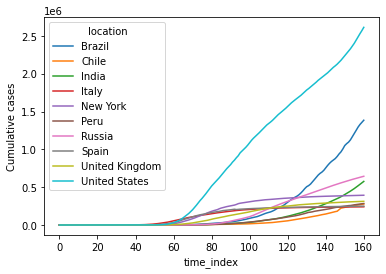

In [21]:
(eda_data[eda_data.location.isin(toptencase_locations)].set_index(['time_index', 'location'])
).total_cases.unstack().plot()
plt.ylabel('Cumulative cases')
plt.savefig('top_10_cases_cumulative.jpg', bbox_inches='tight')

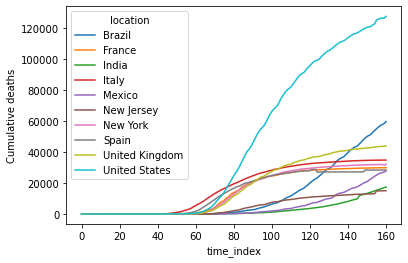

In [22]:
eda_data[eda_data.location.isin(
                                 (eda_data.set_index(['time_index', 'location']).total_deaths
                                 ).groupby(level=1).max().sort_values()[-10:].index
                               )].set_index(['time_index', 'location']).total_deaths.unstack().plot()


plt.ylabel('Cumulative deaths')
plt.savefig('top_10_deaths_cumulative.jpg', bbox_inches='tight')

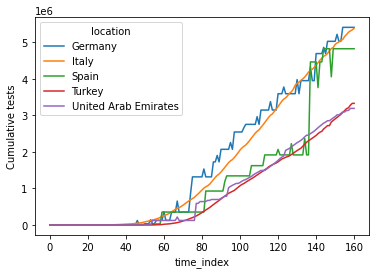

In [23]:
eda_data[eda_data.location.isin(eda_data.set_index(['time_index', 'location']).total_tests.groupby(level=1).max().sort_values()[-10:-5].index)].set_index(['time_index', 'location']).total_tests.unstack().plot()
_ = plt.ylabel('Cumulative tests')
plt.savefig('top_10_tests_cumulative.jpg', bbox_inches='tight')

In [24]:
for features in ['total_tests', 'total_cases', 'total_deaths']:
    eda_data = fix_incorrect_decrease(eda_data, features, search_threshold='match')

Fixing 68 countries in the total_tests column feature
Fixing 59 countries in the total_cases column feature
Fixing 48 countries in the total_deaths column feature


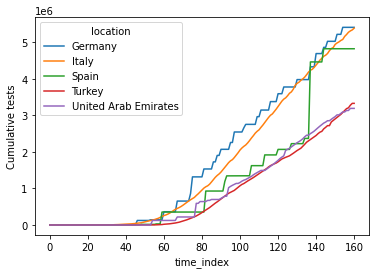

In [25]:
eda_data[eda_data.location.isin(eda_data.set_index(['time_index', 'location']).total_tests.groupby(level=1).max().sort_values()[-10:-5].index)].set_index(['time_index', 'location']).total_tests.unstack().plot()
_ = plt.ylabel('Cumulative tests')
plt.savefig('top_10_tests_cumulative_corrected.jpg', bbox_inches='tight')

Label the columns with the data sources because otherwise there are repeated column names which is a pain to deal with
later on in the data exploration process.

In [26]:
for country_indices in country_groupby(eda_data):
    eda_data.loc[country_indices, column_search(eda_data,'population')] = \
    eda_data.loc[country_indices,  column_search(eda_data,'population')].fillna(method='ffill').fillna(method='bfill').values 

This is a work around for the fact that both jhucsse datasets have a column labeled "deaths", and so unless I make the distinction between jhucsse_global and jhucsse_usa this will cause issues. This distinction causes issues as well and so I find it easier to just drop it.

In [27]:
death_copy = eda_data.iloc[:,3].copy()
eda_data = eda_data.drop(columns=['deaths_jhucsse'])
eda_data = pd.concat((eda_data.iloc[:,:3], death_copy,eda_data.iloc[:,4:]),axis=1)

Because I have found the best results with using only the new cases per million people feature and the government response index feature, I can increase the number of locations by reducing the number of datasets used to produce the model data. 
***Note this is a big change relative to the old versions of this notebook***

In [28]:
global_data = [owid_df, oxcgrt_df]

names = ['owid','oxcgrt']
export_list = []

export_list_tmp, dates_intersection, country_intersection = regularize_time_series(global_data, 
                                                                                   location_operation='intersection',
                                                                                  date_operation='intersection')
for i, x in enumerate(export_list_tmp):
    gd_export_copy = x.copy()
    gd_export_copy.columns += '_' + names[i]
    export_list.append(gd_export_copy)

data_concat = pd.concat(export_list, axis=1)
# hong kong is pathologically valued w.r.t. total_cases_per_million_owid
data_concat = data_concat.loc[data_concat.index.get_level_values(0)!='Hong Kong',:]
data = add_time_indices(multiindex_to_table(data_concat), index_column='total_cases_per_million_owid')

# Want the data separated by country, the diamond princess does not have the vast majority of feature data.
data = data[~data.location.isin(['Diamond Princess','World'])]
print('The range of all dates is from {} to {}'.format(dates_intersection.min(), dates_intersection.max()))
print('The final number of locations included is {}'.format(len(country_intersection)))

30927 30927
The range of all dates is from 2020-01-01 00:00:00 to 2020-07-01 00:00:00
The final number of locations included is 170


The "main" DataFrame to be exported does not distinguish between the different data sets.

In [29]:
dataframe_list, modeling_dates, modeling_countries = regularize_time_series(global_data, location_operation='intersection',
                                                                                  date_operation='intersection')

print('The range of all dates is from {} to {}'.format(modeling_dates.min(), modeling_dates.max()))
print('The number of countries included is {}'.format(len(modeling_countries)))
# Convert the multiindex DataFrame to a simple table, and then add numerical features which track the
# date and # of days since first case. 
dataframe_temporary = pd.concat(dataframe_list, axis=1)
dataframe_temporary = dataframe_temporary.loc[dataframe_temporary.index.get_level_values(0)!='Hong Kong',:]

# hong kong is pathologically valued w.r.t. total_cases_per_million_owid
df = add_time_indices(multiindex_to_table(dataframe_temporary), index_column='total_cases_per_million')
# keep the OWID per million features separately. 
saved_per_million = df.loc[:, column_search(df, 'per_million')].copy()
df = df.drop(columns=column_search(df, 'per_million'))

The range of all dates is from 2020-01-01 00:00:00 to 2020-07-01 00:00:00
The number of countries included is 170
30927 30927


Create an index/list of the features which *should* be cumulative. Then fix their values using
forward filling / zero filling.

In [30]:
cumulative_columns = pd.Index(column_search(df, 'cases').unique().tolist()
                      +column_search(df, 'deaths').unique().tolist()
                      +column_search(df, 'tests').unique().tolist())
cumulative_columns = cumulative_columns[~cumulative_columns.str.contains('new')].drop('tests_units')


The number of incorrectly decreasing values.

In [31]:
(df.set_index([df.time_index, df.location]).loc[:, cumulative_columns
                                              ].groupby(level=1).diff(1).fillna(0) < 0).sum()#.drop_duplicates()

total_cases                 14
confirmed_cases             14
total_deaths                 2
confirmed_deaths             2
total_tests                  5
total_tests_per_thousand     5
dtype: int64

An example of three countries' time series for the total cases (which should be cumulative).

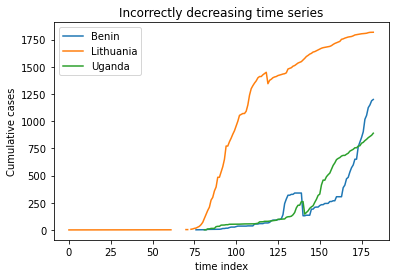

In [32]:
fig, ax = plt.subplots()
_ = ax.plot(df[df.location == 'Benin'].total_cases.values, label='Benin')
_ = ax.plot(df[df.location == 'Lithuania'].total_cases.values, label='Lithuania')
_ = ax.plot(df[df.location == 'Uganda'].total_cases.values, label='Uganda')
_ = ax.set_ylabel('Cumulative cases')
_ = ax.set_xlabel('time index')
_ = ax.set_title('Incorrectly decreasing time series')
_ = plt.legend()
plt.savefig('three_cases_incorrect_decrease.jpg', bbox_inches='tight')

Usage of custom function to fill in missing values, as well as check the validity of the time series. Mainly,
this means making sure that non-decreasing quantities in fact behave this way. It checks the difference between values $n$ and
$n+1$. If negative, the value at $n+1$ is replaced with the previous day's value. If this creates a new discrepancy, (i.e. $n+2$ is smaller then $n+1$ post-update, then it will be handled upon the next scan). Tried to make it as simple as possible to avoid any strange interactions; technically, the approximate slopes are calculated all at once and the values are updated all at once; instead of starting from the beginning and sweeping all the way through the time series. This approximation always propagates forwards, and by virtue of its calculation, always takes the larger value to be the truth. 

In [33]:
for features in cumulative_columns:
    df = fix_incorrect_decrease(df, features, search_threshold='match')

Fixing 10 countries in the total_cases column feature
Fixing 10 countries in the confirmed_cases column feature
Fixing 2 countries in the total_deaths column feature
Fixing 2 countries in the confirmed_deaths column feature
Fixing 2 countries in the total_tests column feature
Fixing 2 countries in the total_tests_per_thousand column feature


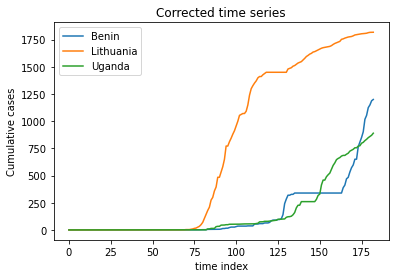

In [34]:
fig, ax = plt.subplots()
_ = ax.plot(df[df.location == 'Benin'].total_cases.values, label='Benin')
_ = ax.plot(df[df.location == 'Lithuania'].total_cases.values, label='Lithuania')
_ = ax.plot(df[df.location == 'Uganda'].total_cases.values, label='Uganda')
_ = ax.set_ylabel('Cumulative cases')
_ = ax.set_xlabel('time index')
_ = ax.set_title('Corrected time series')
_ = plt.legend()
plt.savefig('three_cases_incorrect_decrease_corrected.jpg', bbox_inches='tight')

The next set of computations handles missing values. The key consideration is
to not contaminate the time series with information from the future. Because I am filling in the missing values here,
I will be flagging the original missing values and keeping these flags as new features.

Originally I pruned the lowest 10% population countries, because the countries with very small populations are 
quite pathological for the new_cases_per_million feature (i.e. the vatican has the highest values.)
I've changed my mind regarding how this should be handled and have decided to only take countries with populations
greater than one million, such that the per capita division doesn't actually result in magnification.

Fill in missing values which cannot be imputed because they exist nowhere in the dataset 

In [35]:
df.population_density.nunique(), df.location.nunique()

(166, 169)

In [36]:
# To prevent the SettingCopyWithSlice warning use loc, which needs index values, hence
# the application of this workaround function. 
data.loc[country_search(df, 'South Sudan'), 'population_density'] = 20.3
df.loc[country_search(df, 'South Sudan'), 'population_density'] = 20.3

df.loc[country_search(df, 'Guinea Bissau'), 'population_density'] = \
df.loc[country_search(df, 'Guinea Bissau'), 'population_density'].max()


for country_indices in country_groupby(df):
    df.loc[country_indices, ['population','population_density']] = \
    df.loc[country_indices,  ['population','population_density']].fillna(method='ffill').fillna(method='bfill').values 

df = df[df.population > 1000000.]
# these two countries have pathological new_cases_per_million time series. just get rid of them for simplicity
df = df[~df.location.isin(['Chile', 'Ecuador'])]
data = data[data.location.isin(df.location.unique())]
per_million_population = df.population / 1000000.
population_density = df.population_density
world_pop = df[df.time_index==df.time_index.max()].population.sum()
percent_pop = df.population / world_pop
data.loc[:, 'per_million_population'] = per_million_population.values

In [37]:
df.population_density.nunique(), df.location.nunique()

(144, 146)

<a id='features'></a>
# 6. Feature engineering and selection
[Return to table of contents](#toc)

I primarily use qualitative means to select the features I will use in the modeling phase. This is perhaps the biggest gap of the project, but I did use the training data to eliminate bad choices for features but the number of experiments is too large to be useful to include in a notebook. Regardless, I will decide on features to discard and features to create in this next section. The first matter to attend to is to remove feature columns which simply contain redudant feature information, such as repeats of the number of total cases, etc.

#### Choice of dependent variable
Perhaps the most important step in this entire process is to select the dependent variable which will be predicted. I believe the most prudent quantity is the new cases per million people.

The first selection step is to simply remove the columns which contain redundant information.

In [38]:
# redundant features; some features contain the same substring but are not redundant, hence the use of .difference()
redundant_death_columns = column_search(df, 'death').difference(['cvd_death_rate'])
redundant_test_columns = column_search(df, 'test').difference(['tests_units','h2_testing_policy'])
redundant_case_columns= column_search(df, 'cases')

In [39]:
data.loc[data.new_cases_per_million_owid<0, 'new_cases_per_million_owid'] = 0

# Already have a good "new cases" feature, so do not need to compute differences
df.loc[:, 'new_cases_per_million'] =  data.loc[df.index,'new_cases_per_million_owid'].fillna(0).values
data.loc[:, 'new_cases_per_million'] = data.loc[df.index,'new_cases_per_million_owid'].fillna(0).values
df.loc[:, 'log_new_cases_per_million'] = df.loc[:, 'new_cases_per_million'].apply(lambda x: np.log(x+1))

In [40]:
# this is required from the step dropping the least populated countries
# but it could not be done until after the dependent variable was created.
df = df.reset_index(drop=True)
df_pruned = df.drop(columns=(redundant_death_columns.tolist() 
                         + redundant_test_columns.tolist() 
                         + redundant_case_columns.tolist()))

Next is to remove the columns without any utility (i.e. all entries equal a single value) and those which are essentially
identical to others.

In [41]:
response =  data.loc[:, 'government_response_index_oxcgrt']
df_pruned = df_pruned.drop(columns=['country_name', 'country_code',
                                                    'm1_wildcard','stringency_index_for_display',
                                                   'stringency_legacy_index', 'stringency_legacy_index_for_display',
                                                    'government_response_index_for_display',
                                                    'containment_health_index_for_display',
                                                    'economic_support_index_for_display',
                                                    'iso_code','stringency_index'])
df_pruned.loc[:, 'government_response_index'] = response.values

#### Collecting all predictor variables.

Enumerate all feature names by explicity writing lists and slicing column names from the relevant DataFrame. This allows me to reorder the columns by category and type to suit my personal preference and to keep track of the names of features relevant to the separate datasets.

In [42]:
indexers = ['location','date','time_index','days_since_first_case']
new_per_million_quantity_features = ['new_cases_per_million']
log_new_per_million_quantity_features = ['log_new_cases_per_million']
flag_features = column_search(df_pruned,'flag')
time_independent_features =df_pruned.loc[:, 'population':'hospital_beds_per_thousand'].columns.tolist()
time_dependent_features = (df_pruned.loc[:, 'c1_school_closing':'economic_support_index'].columns
                          ).difference(flag_features).tolist()

categorical_features = flag_features.tolist()+['tests_units', 'continent']
numerical_features =  (new_per_million_quantity_features
                       +log_new_per_million_quantity_features
                       +time_dependent_features)
new_quantity_features =  (new_per_million_quantity_features
                       +log_new_per_million_quantity_features)

Create/select the dependent variable (and its logarithm) to use in the modeling process.

In [43]:
df_reorder = df_pruned.loc[:, indexers
                              +numerical_features
                              +time_independent_features
                              +categorical_features]

Manipulate categorical features and fill in missing values with string ```'Missing'```
The original OxCGRT flag columnstake values 1.0, 0.0, np.nan. 
Convert these to categorical, and for the sake of column names map floats to str.
Afterwards, drop the column that corresponds to missing values to remove collinearity. 

*Note that the distinction between regression and cnn data is deprecated but kept in case of changes.

In [44]:
categorical_df = df_reorder.loc[:, categorical_features].fillna('Missing').astype('category')
for col in categorical_df.columns:
    categorical_df.loc[:, col] = categorical_df.loc[:, col].cat.rename_categories({1.0 : '1', 0. : '0'})
    
categorical_dummies = pd.get_dummies(categorical_df)
categorical_dummies_without_collinearity = regularize_names(categorical_dummies[categorical_dummies.columns[~categorical_dummies.columns.str.contains('Missing')]])

In [45]:
df_reorder = pd.concat((df_reorder.drop(columns=categorical_features),
                        categorical_dummies_without_collinearity),axis=1)
categorical_dummy_features = categorical_dummies_without_collinearity.columns.tolist()

Because I'm going to impute values for the time independent features, it may or may not be important to track this by flagging
the missing values via one-hot encoding. Note that I have just manipulated the flagging columns so that *their* missing value flags are not included; but again this is because of linear dependency reasons. 

In [46]:
# only create missing flag variables for features that are missing more than a minimum number of values (100)         
missing_categoricals = df_reorder.iloc[:, np.where(df_reorder.isna().sum() > 100)[0]].isna().astype(int)
missing_categoricals.columns = missing_categoricals.columns + '_missing_flag'

Deal with missing values with strategies that are dependent upon where or not the feature is time dependent or not.
For time independent features, do not have to be careful with time; because there is no two-sided fillna method that
I am aware of, handle this by filling forwards and backwards.
Time dependent features can only be filled forward so that information from the future is not visible from the past. Additionally, any other missing values are filled with 0's; only other options would be, for instance, the mean up to that date. 

In [47]:
for country_indices in country_groupby(df_reorder):
    fill_tmp = df_reorder.loc[country_indices, time_independent_features].fillna(method='ffill').fillna(method='bfill')
    df_reorder.loc[country_indices, time_independent_features] = fill_tmp.values
    df_reorder.loc[country_indices, time_dependent_features] = df_reorder.loc[country_indices, time_dependent_features].fillna(method='ffill').fillna(value=0)
df_reorder.loc[:, time_independent_features] = df_reorder.loc[:, time_independent_features].fillna(df_reorder.loc[:, time_independent_features].median())

Compose the DataFrame with all engineered and original features.

In [48]:
location_dummies_without_collinearity = pd.get_dummies(df.location, drop_first=True)
location_dummies_without_collinearity.columns += '_location_flag'
location_dummies_without_collinearity = regularize_names(location_dummies_without_collinearity)
export_df = pd.concat((df_reorder, location_dummies_without_collinearity, missing_categoricals),axis=1)
export_df = export_df.loc[:, indexers 
                  + new_per_million_quantity_features 
                  + log_new_per_million_quantity_features
                  + time_dependent_features
                  + time_independent_features
                  + categorical_dummy_features
                  + location_dummies_without_collinearity.columns.tolist()
                  + missing_categoricals.columns.tolist()
                 ]

#### Features selection for modeling

Finally we've reached the time to explain the motivating factors behind the choice of features for each model's training.
Originally I thought that all COVID related time series should be included. The argument that I use to exclude the deaths, and recovered patients is that they are time delayed effects relative to the number of new cases. The exclusion of new tests is due to the lack of consistent units. Due to this, what seems like a single feature actually must be split into multiple different features, one for each unit (this is actually possible because the units are included and now, one-hot encoded).

I do not include any categorical or time independent features, because of how the data will be arranged into time-windows or frames, such that each sample (row of an array) consists of multiple days of data, I can either append the time independent features (i.e. do not include copies) but I instead focus on the time dependent data. The reason I use to justify this is that I want the models to use comparable amount of information, and the format of the neural networks doesn't really facilitate time independent features.

Create the moving averages of the time dependent features to attempt to convey the time dependence to the regression models. 
Previously, I used rolling window widths of 7, 14, 21, 28 days but upon inspection the 21 and 28 day MA simply introduced a number of nearly collinear features, which in turn affects the ridge regression. I have elected to change to 3, 7, 14. 7 and 14 to capture the seasonality. My rationale for the 3-day moving average isn't as strong, but sometimes the time series are erratic and so I want to accurately capture the time-series but also slightly mitigate these "outliers".

Likewise, there is a very important modification which I employ to "fix" the time series. There are instances presumable reporting errors wherein a time series, new cases for example, has an unrealistic, errant 0. These are unrealistic because simply because a 0 was reported doesn't mean the actual pandemic was kind enough to pause for a day. Therefore I will modify these few unfortunate values by forward filling (i.e. using previous days values).

The features selected for the regression process include the new cases per million time series, its logarithm, the government response index, and their moving averages. 

In [49]:
roll_widths = [3, 7, 14]

lean_features_list =  (indexers 
                       + new_per_million_quantity_features 
                       + log_new_per_million_quantity_features
                       + ['government_response_index'])
numerical_features = (new_per_million_quantity_features 
                      + log_new_per_million_quantity_features
                      + ['government_response_index'])
modeling_df = modify_time_series_zeros(export_df.loc[:, lean_features_list].copy(), 
                                                        new_per_million_quantity_features 
                                                          + log_new_per_million_quantity_features)

In [50]:
new_features = rolling_means(modeling_df.copy(), numerical_features,
                                     roll_widths=roll_widths).reset_index(drop=True)

modeling_df = pd.concat((modeling_df,
                                new_features,
                               ),axis=1)
#Comment out to "freeze" the saved data
if not os.path.isfile('data.csv'):
    modeling_df.drop(ciolumns='date').fillna(0).to_csv('model_data.csv')

#### Feature engineering for the data used in exploration. 

Calculate moving averages here to save space in exploration notebook. These features are indeed used in the regression modeling process but they are also nice to have for time-series plotting purposes as we can use the rolling means and standard deviations to give some sense of the volatility and average values.

In [51]:
# use multiples of 7 to capture weekly seasonality
roll_widths = [3, 7, 14]

new_features = rolling_features(eda_data, 
                                  eda_data.select_dtypes(include='number').columns, 
                                  roll_widths=roll_widths)

export_to_eda = pd.concat((eda_data,
                                new_features.reset_index(drop=True)
                               ),axis=1)

To avoid mixing data types upon export / import in other notebooks, replace the ```NaN``` values in object columns with the
string ```'Missing'```

In [52]:
export_to_eda.loc[:, export_to_eda.select_dtypes(include='object').columns] = \
export_to_eda.loc[:, export_to_eda.select_dtypes(include='object').columns].fillna('Missing')

The last step before I export the data is to create my own features which represent the number of "new" daily values for cases, tests, etc. The reason for this is to check and ensure that these values are consistent with the other, total values reported as well as demonstrate the differences with the "repair" of the cumulative variables performed previously.

In [53]:
tmp = eda_data.loc[:, column_search(eda_data, 'total').tolist()+['location']].groupby('location').diff(1).fillna(0)
tmp.columns = 'new_' + tmp.columns
tmp.sample(5)

tmp_per_mill = tmp / np.tile((eda_data.population_owid.values.reshape(-1,1)/1000000.),(1,9))
tmp_per_mill.columns += '_per_million'

eda_final = pd.concat((export_to_eda, tmp, tmp_per_mill),axis=1)
if not os.path.isfile('data.csv'):
    eda_final.to_csv('data.csv')